## Solar

Project Solar is an attempt to equire information about sourounding envrionment in a living space, analize it, and build predictions in order to answer:

> Determine value of artificial light to counteract its natural deficit

#### Data aquisition and uniqness

In [154]:
import pandas as pd

In [155]:
import datastore as ds
con = ds.connect()

In [156]:
df = pd.read_sql('SELECT * FROM sensing', con=con)

In [157]:
print('Number of samples:', df['id'].count())
df.drop_duplicates(subset='time', keep="last", inplace=True)
print('Number of unique samples:', df['id'].count())

Number of samples: 384594
Number of unique samples: 373632


In [158]:
df[['light','sound']].describe()

,light,sound
count,373632.000000,373632.000000
mean,479.857954,1278.420316
std,508.493650,275.753610
min,-0.180000,0.000000
25%,2.790000,1058.190000
50%,281.100000,1274.560000
75%,916.060000,1542.760000
max,2047.000000,2047.000000


Setting up index 

In [159]:
df['timestamp']=pd.to_datetime(df['time'].apply(lambda x: x[:-7]))
df.set_index('timestamp', inplace=True)

#### Scaling 

In [160]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

df['light_scaled'] = mm.fit_transform(df['light'].values.reshape(-1,1))
df['sound_scaled'] = mm.fit_transform(df['sound'].values.reshape(-1,1))

#### Visualization

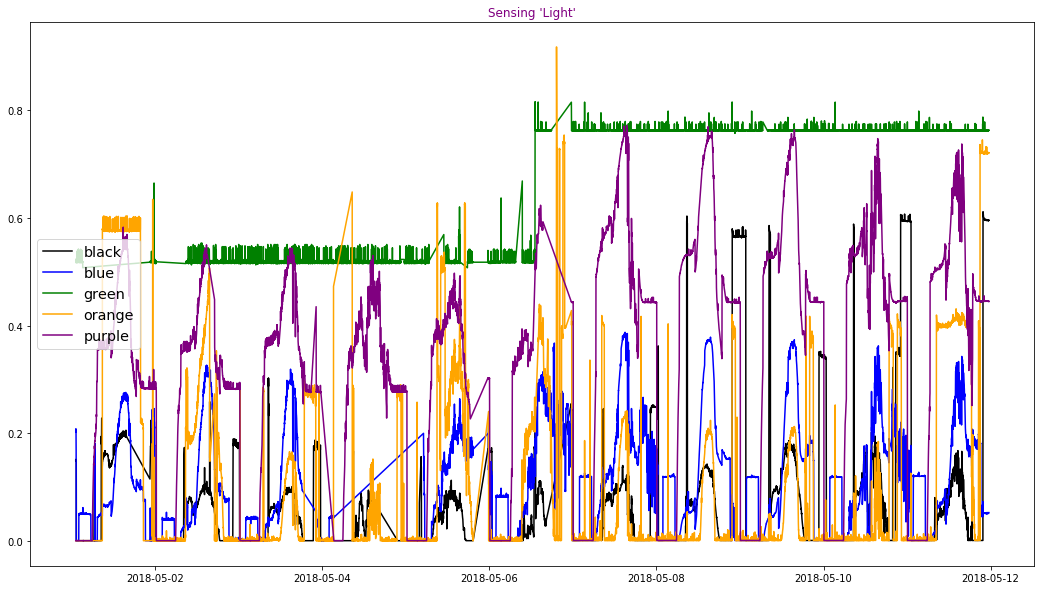

In [162]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def draw_sensing(data, title = ''):
    fig, ax = plt.subplots(figsize=(18, 10))
    data.head()
    for location in data.index.get_level_values(0).unique():
        ax.set_title('Sensing {!r}'.format(title), color=location)
        ax.plot(data.loc[location], label=location, color=location)
    ax.legend(loc=6, fontsize='x-large')

draw_sensing(df[['light_scaled', 'location']].groupby(['location', 'timestamp']).agg({'light_scaled':'mean'}), 'Light')

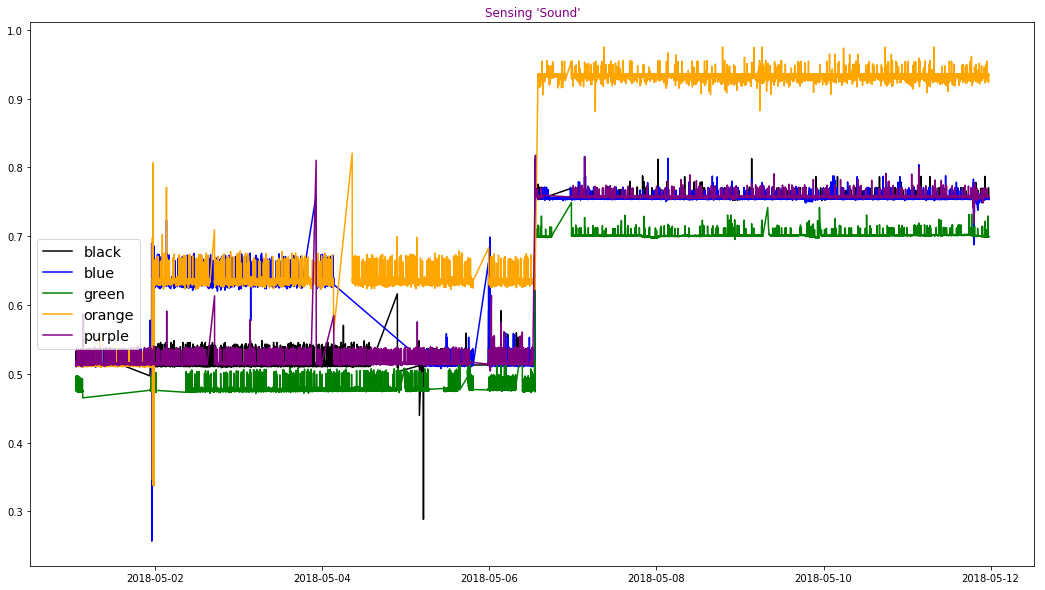

In [163]:
draw_sensing(df[['sound_scaled', 'location']].groupby(['location', 'timestamp']).agg({'sound_scaled':'mean'}), 'Sound')

#### Motion heatmap

In [164]:
location = pd.get_dummies(df[['location']], prefix='location')

In [165]:
df_located = pd.concat([df, location], axis=1, join='outer')

In [166]:
times = pd.DatetimeIndex(df_located['time'])
motion_df = df_located.groupby([
    df_located.index.get_level_values('timestamp').hour,
    'location_black', 
    'location_blue', 
    'location_green', 
    'location_orange', 
    'location_purple']).agg({'motion':'sum'})

Text(0.5,365.509,'Time')

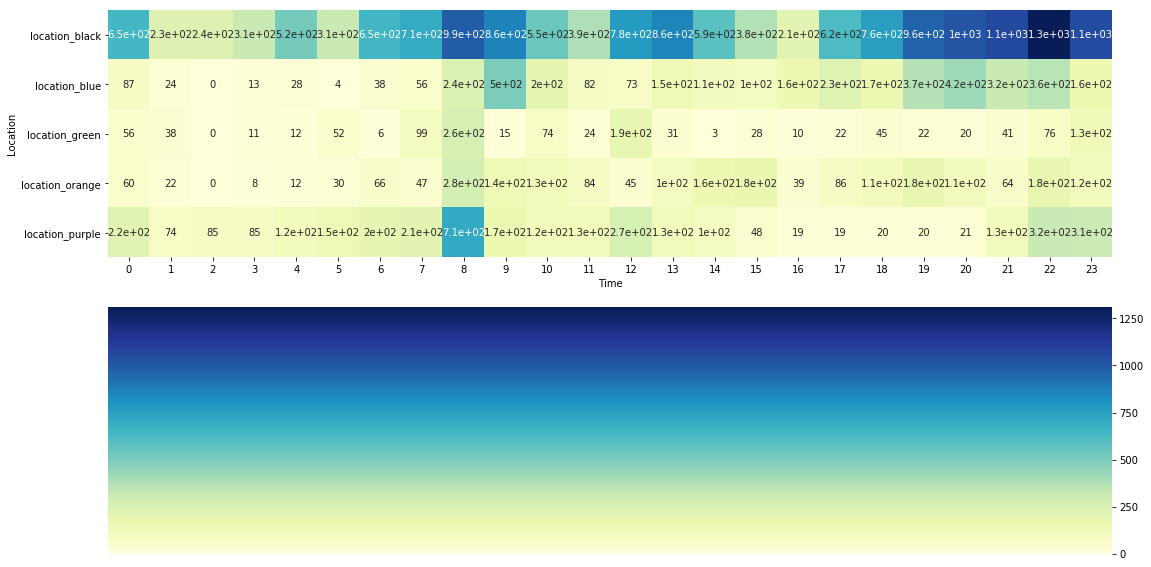

In [167]:

import seaborn as sns
import re
f, (ax, cbar_ax) = plt.subplots(2, figsize=(18, 10))
xtick = motion_df.index.get_level_values('timestamp').unique()
ytick = list(map(lambda x: re.sub(r'location__', '', x), motion_df.index.names[1:]))
ytick
sns.heatmap(motion_df.unstack(level=[0]), yticklabels=ytick, xticklabels=xtick, ax=ax, cbar_ax=cbar_ax, annot=True, cmap="YlGnBu")
ax.set_ylabel('Location')
ax.set_xlabel('Time')

#### Add features

In [168]:
sun = pd.get_dummies(df[['sun']], prefix='sun', drop_first=True)

In [169]:
df_sunrized = pd.concat([df_located, sun], axis=1, join='outer')

In [170]:
df_sunrized.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373632 entries, 2018-05-01 01:09:00 to 2018-05-11 23:29:00
Data columns (total 20 columns):
id                 373632 non-null int64
light              373632 non-null float64
sound              373632 non-null float64
motion             373632 non-null int64
location           373632 non-null object
sun                373632 non-null object
time               373632 non-null object
light_scaled       373632 non-null float64
sound_scaled       373632 non-null float64
location_black     373632 non-null uint8
location_blue      373632 non-null uint8
location_green     373632 non-null uint8
location_orange    373632 non-null uint8
location_purple    373632 non-null uint8
sun_evening        373632 non-null uint8
sun_morning        373632 non-null uint8
sun_night          373632 non-null uint8
sun_noon           373632 non-null uint8
sun_sunrise        373632 non-null uint8
sun_sunset         373632 non-null uint8
dtypes: float64(4), int6

Adding the day of the week

In [203]:
day_of_week = pd.DataFrame(df_sunrized.index.get_level_values('timestamp').dayofweek, index=df_sunrized.index)
day_of_week.rename(columns=lambda x: 'dot_week', inplace=True)
df_weekday = pd.concat([df_sunrized, day_of_week], axis=1, join='outer')

#### Review & improve light & sound distribution

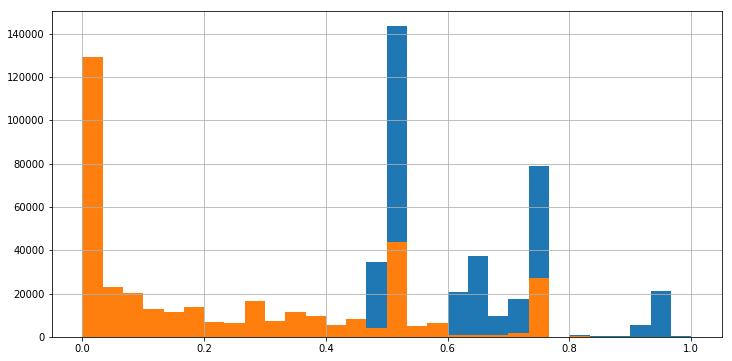

In [223]:
import numpy as np
df_weekday['sound_scaled'].hist(bins=30, figsize = (12,6))
df_weekday['light_scaled'].hist(bins=30, figsize = (12,6))

In [230]:
df_weekday['sound_log_scaled'] = np.abs(np.log(df_weekday['sound_scaled']))
df_weekday['light_log_scaled'] = np.abs(np.log(df_weekday['light_scaled']))

/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [231]:
df_weekday['sound_log_scaled'] = df_weekday['sound_log_scaled'].apply(lambda x: 0 if np.isinf(x) else x)
df_weekday['light_log_scaled'] = df_weekday['light_log_scaled'].apply(lambda x: 0 if np.isinf(x) else x)

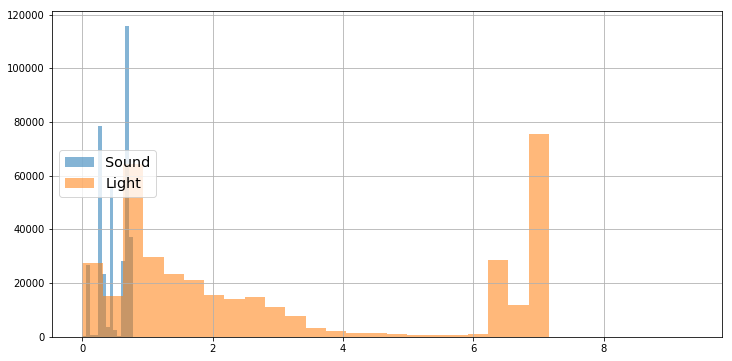

In [232]:
fig, ax = plt.subplots(figsize=(18, 10))
df_weekday['sound_log_scaled'].hist(bins=30, figsize = (12,6), label='Sound', alpha=.55)
df_weekday['light_log_scaled'].hist(bins=30, figsize = (12,6), label='Light', alpha=.55)
ax.legend(loc=6, fontsize='x-large')

#### Export data for further research

In [233]:
df_numeric = df_weekday.drop(['id','light','location','time','sun','sound'], axis=1)

In [234]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373632 entries, 2018-05-01 01:09:00 to 2018-05-11 23:29:00
Data columns (total 17 columns):
motion              373632 non-null int64
light_scaled        373632 non-null float64
sound_scaled        373632 non-null float64
location_black      373632 non-null uint8
location_blue       373632 non-null uint8
location_green      373632 non-null uint8
location_orange     373632 non-null uint8
location_purple     373632 non-null uint8
sun_evening         373632 non-null uint8
sun_morning         373632 non-null uint8
sun_night           373632 non-null uint8
sun_noon            373632 non-null uint8
sun_sunrise         373632 non-null uint8
sun_sunset          373632 non-null uint8
dot_week            373632 non-null int64
sound_log_scaled    373632 non-null float64
light_log_scaled    373632 non-null float64
dtypes: float64(4), int64(2), uint8(11)
memory usage: 23.9 MB


In [235]:
df_numeric.to_pickle('data/sensing_numeric.pkl')